In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.linear_model
import xgboost as xgb
from pytil.object import Namespace as O
from pytil.utility import *
from helpers import *
from pytil.quickvis import canvas

import random
ss = slice(None)
canvas(16, 2)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:11:22.244766. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
N_TRAIN, N_TEST = 623817, 640430
df = pd.read_csv('train.csv', index_col=0)
df.index = df.index - N_TRAIN
dg = pd.read_csv('test.csv', index_col=0)
dh = pd.concat([df, dg])
n_stock = len(set(dh.Stock))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:11:23.902220. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Explore

In [3]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()
idfeats = 'Market Stock'.split()

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:11:29.889189. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
raise Exception("Don't go on blindly!")

## feature explore

In [ ]:
sortdh = dh.sort_values('Day')
res = [None] * n_stock
for idx, ((markt, stock), td) in enumerate(sortdh.groupby(['Market', 'Stock'])):
    data = [np.inf]
    for i in range(1, 200):
        roll = td.rolling(i, center=True, min_periods=1)
        est = (roll.y.sum() - td.y) / (roll.y.count() - 1)
        data.append((td.Weight * (est - td.y) ** 2).sum())
    res[stock] = min(range(len(data)), key=lambda x: data[x])
    if idx % 100 == 0:
        print(idx)

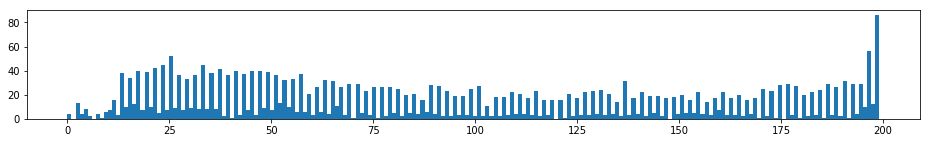

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:18:24.639794. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [542]:
plt.hist(res, bins=200);

In [ ]:
13, 25, 33, 57

## old things

In [724]:
agrp = np.abs(df).groupby('Market Stock'.split())
wycorr = agrp.corr().loc[(slice(None), slice(None), 'Weight',), ('y',)]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:16.747078. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


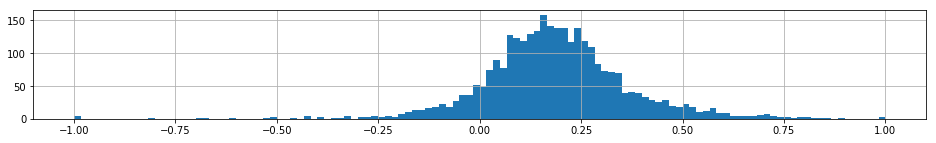

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:31.051520. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [725]:
res = agrp.corr().loc[(ss, ss, 'y'), 'x4']
res.hist(bins=120)

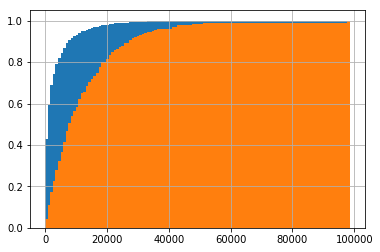

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:11:33.695777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [341]:
hist(grp.sum().Weight, bins=120, normed=True, cumulative=True)
hist(grp.sum().Weight, weighted=True, bins=120, normed=True, cumulative=True)

In [394]:
listthing = [int(x[0]) for x in sorted(df[['Stock', col]].values, key=lambda x: x[1])[::-1][-1000:-500]]
thing = list(set(listthing))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:21:28.672423. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


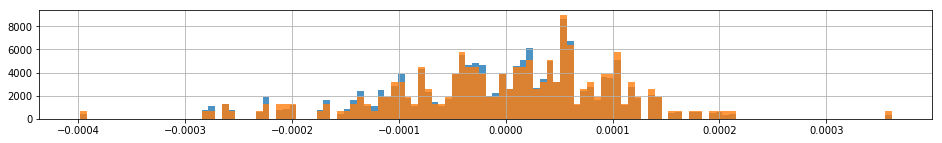

247 0.000397538089951


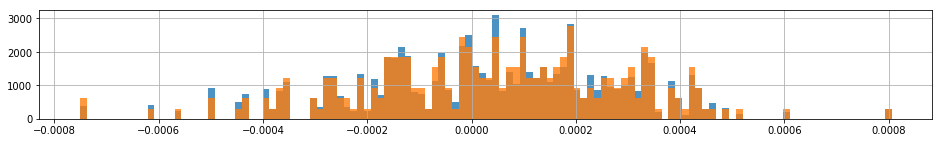

251 0.0867626267151


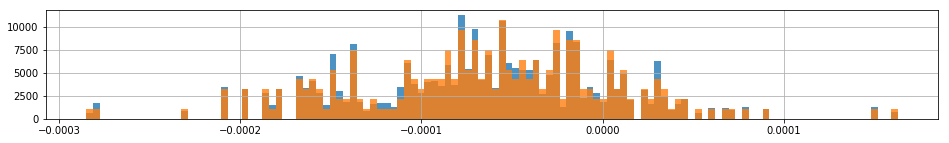

251 0.204674285411


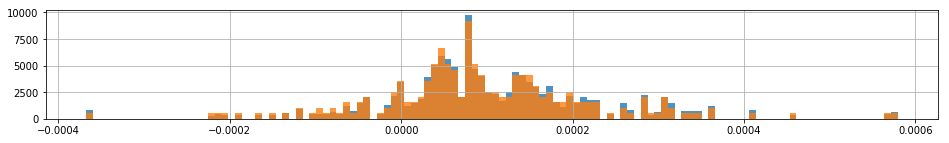

247 1.42622882884e-05


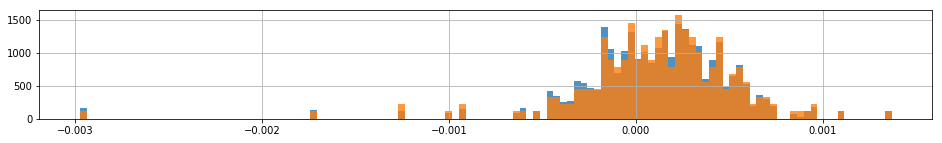

247 1.6676556502e-31


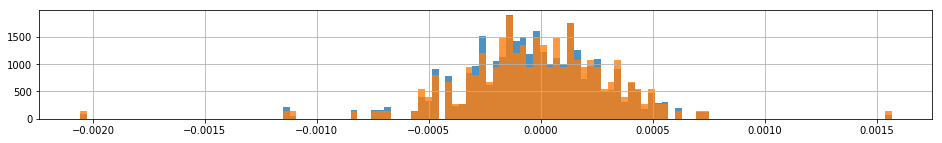

247 9.22979973834e-14


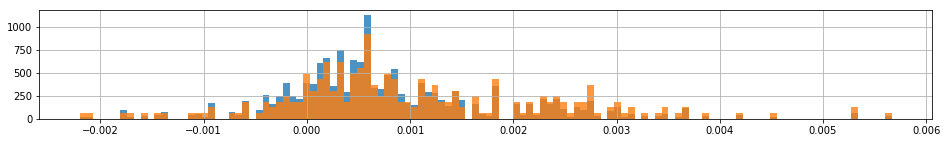

249 9.59286090927e-06


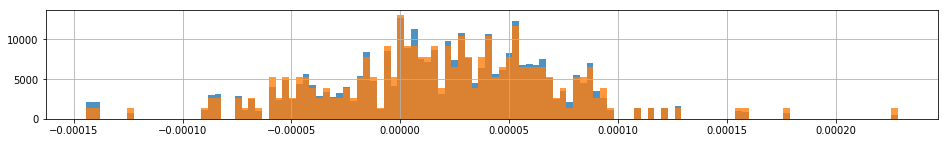

247 0.0197578412492


C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:25:03.178891. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [744]:
col = 'y'
from scipy import stats
ii = list(range(df.Stock.min(), df.Stock.max() + 1))
random.shuffle(ii)
ii = ii[:8]
#ii = thing
for i in range(len(ii)):
    q = df.query('Stock == ' + str(ii[i]))
    trans = q[col]
    trans.hist(bins=120, weights=q.Weight, normed=True, alpha=.8)
    trans.hist(bins=120, normed=True, alpha=.8)
    plt.show()
    print(len(trans), stats.normaltest(trans).pvalue)

## cv days selection

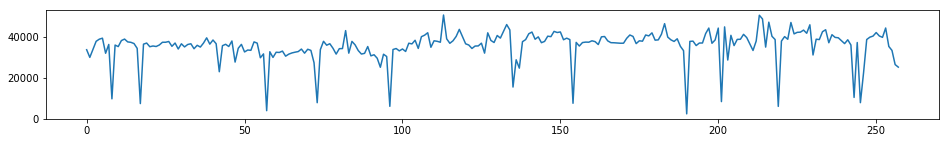

In [84]:
days = sorted(set(df.Day))
weights = [df.query('Day == ' + str(day)).Weight.sum() for day in days]
plt.plot(weights); plt.show()

# Simple model

In [ ]:
# +2 to day to get 0 % 7 == Monday

In [5]:
market = pd.get_dummies(dh[['Market']], columns=['Market'])
#stock = pd.get_dummies(dh[['Stock']], columns=['Stock'])
#day = pd.get_dummies(dh[['Day']], columns=['Day'])

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:11:30.232648. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [240]:
dayseg = dh['Day']
off0 = (dayseg + 2) // 14
off0.name = 'Biweek0'
off1 = (dayseg + 2 + 7) // 14
off1.name = 'Biweek1'
dayseg = pd.concat([off0, off1], axis=1)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 10:21:17.302355. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [225]:
wkdfeats = 'Monday Tuesday Wednesday Thursday Friday'.split()
weekday = ((dh.Day + 2) % 7)
weekday = weekday.map({i: s for i, s in enumerate(wkdfeats)})
weekday = pd.get_dummies(weekday)
weekday = weekday[wkdfeats]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 10:18:08.946198. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [226]:
ranked = 1 - dh.groupby(['Market', 'Stock']).transform(lambda x: x.rank(pct=True, method='max', ascending=False))
ranked = ranked[[c for c in ranked.columns if c != 'Weight' and c != 'y' and c != 'Day']]
ranked.columns = [c + ' rank' for c in ranked.columns]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 10:18:09.331489. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [583]:
windowdh = pd.concat([dh[idfeats], weekday, dh[xfeats], ranked], axis=1)
windowgrp = windowdh.groupby(idfeats)
shifts = []
plains = []
for i in [-1, 1]: # <-- the shifts
    shifted = windowgrp.shift(i)
    if i:
        shifted.columns = [x + ' (' + str(-i) + ')' for x in shifted.columns]
    shifts.append(shifted)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:40:34.124446. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [574]:
def get_rolling_average(x, window):
    roll = x.rolling(window, center=True, min_periods=1)
    est = (roll.sum() - x) / (roll.count() - 1)
    return est
timey = dh.sort_values('Day').groupby(['Market', 'Stock']).y
yrolls = []
for w in range(5, 58, 4): #[13, 25, 33, 57]:
    roll = timey.transform(lambda y: get_rolling_average(y, w))
    roll.name = 'y mean((' + str(w) + '))center'
    yrolls.append(roll)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:34:34.444586. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [416]:
ymean = dh.groupby(['Market', 'Stock']).y.transform('mean')
ymean = ymean.fillna(0)
ymean.name = 'y mean'

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 16:37:52.620005. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [515]:
stockparts = []
for i in range(80):
    randmap = list(range(n_stock))
    random.shuffle(randmap)
    stockpart = dh.Stock.map(lambda x: randmap[x])
    stockpart.name = 'Stock ~' + str(i) + '~'
    stockparts.append(stockpart)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 18:54:50.632042. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [228]:
# 

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 10:18:14.829564. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [123]:
#
try:
    with open('days_order.txt', 'r') as file:
        days = [int(x) for x in file.read().splitlines()]
except FileNotFoundError:
    days = sorted(set(df.Day))
    random.shuffle(days)
    print('new days')
#
n_days = len(days)
days_a, days_b, days_c = set(days[:n_days // 3]), set(days[n_days // 3:(2 * n_days) // 3]), set(days[(2 * n_days) // 3:])
tr, cv, sc = df.Day.isin(days_a), df.Day.isin(days_b), df.Day.isin(days_c)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 23:15:00.885232. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [581]:
#origdh = dh[['Market'] + xfeats]
#thedh = pd.concat([market, stock, weekday, origdh], axis=1)
thedh = pd.concat([dh[xfeats], market, dayseg, weekday, ymean, ranked] + yrolls + shifts, axis=1)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:38:33.352119. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [576]:
xdf = thedh.iloc[:N_TRAIN]
labels = list(xdf.columns)
n = len(df)
x = xdf.values
y = df.y.values #(df.y - ymean).values
weight = df.Weight.values

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:36:00.295353. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [577]:
#n = len(df)
#a = list(range(n))
#random.shuffle(a)
#tr, cv = a[:n // 2], a[n // 2:]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:36:00.701621. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [578]:
dmat = O()
dmat.tr = xgb.DMatrix(x[tr], y[tr], feature_names=labels, weight=weight[tr])
dmat.cv = xgb.DMatrix(x[cv], y[cv], feature_names=labels, weight=weight[cv])
dmat.sc = xgb.DMatrix(x[sc], y[sc], feature_names=labels, weight=weight[sc])

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:36:00.709627. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [579]:
model = None
boost_hp = dict(
    objective = 'reg:linear',
    booste = 'gbtree',
    max_depth = 5, #12,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    tree_method = 'exact',
    gamma = 0.00003,
    min_child_weight = 1000,
    eta = 0.2,
    seed = 0
)
cv_hp = dict(
    num_boost_round = 300,
    early_stopping_rounds = 30,
    nfold = 10,
    stratified = True,
    seed = 0,
)
learn_hp = dict(
    num_boost_round = 300,
    early_stopping_rounds = 30,
    evals = [[dmat.tr, 'Train'], [dmat.sc, 'Score'], [dmat.cv, 'CV']]
)
model = xgb.train(boost_hp, dmat.tr, **learn_hp)

[0]	Train-rmse:0.39999	Score-rmse:0.399987	CV-rmse:0.399989
Multiple eval metrics have been passed: 'CV-rmse' will be used for early stopping.

Will train until CV-rmse hasn't improved in 30 rounds.
[1]	Train-rmse:0.319992	Score-rmse:0.319989	CV-rmse:0.319991
[2]	Train-rmse:0.255994	Score-rmse:0.255991	CV-rmse:0.255993
[3]	Train-rmse:0.204795	Score-rmse:0.204792	CV-rmse:0.204795
[4]	Train-rmse:0.163836	Score-rmse:0.163833	CV-rmse:0.163836
[5]	Train-rmse:0.131069	Score-rmse:0.131066	CV-rmse:0.131069
[6]	Train-rmse:0.104855	Score-rmse:0.104853	CV-rmse:0.104855
[7]	Train-rmse:0.083885	Score-rmse:0.083882	CV-rmse:0.083884
[8]	Train-rmse:0.067108	Score-rmse:0.067105	CV-rmse:0.067107
[9]	Train-rmse:0.053687	Score-rmse:0.053684	CV-rmse:0.053686
[10]	Train-rmse:0.04295	Score-rmse:0.042947	CV-rmse:0.042949
[11]	Train-rmse:0.03436	Score-rmse:0.034358	CV-rmse:0.03436
[12]	Train-rmse:0.027489	Score-rmse:0.027487	CV-rmse:0.027489
[13]	Train-rmse:0.021992	Score-rmse:0.02199	CV-rmse:0.021992
[14]	Tra

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:36:02.521412. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


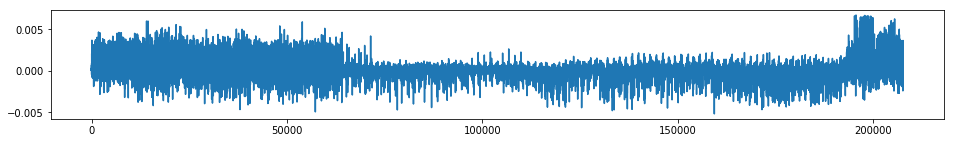

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:30:25.702557. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [563]:
y_ = model.predict(dmat.tr)
plt.plot(y_);

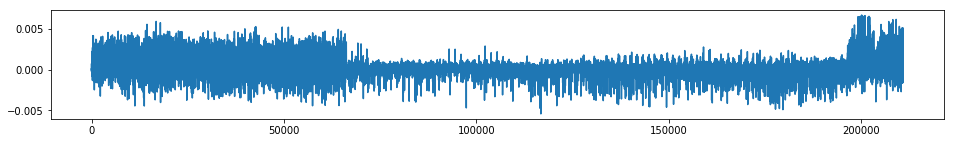

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:05:32.007549. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [529]:
y_ = model.predict(dmat.sc)
plt.plot(y_);

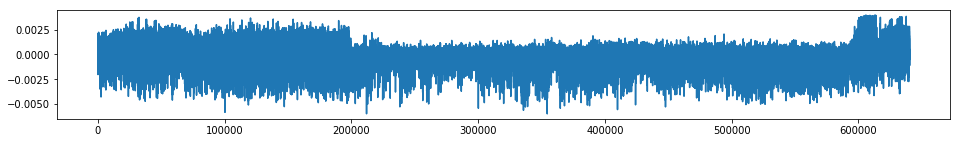

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:05:36.390072. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [530]:
xtest = thedh.iloc[N_TRAIN:].values
dmat.test = xgb.DMatrix(xtest, feature_names=labels)
ytest_ = model.predict(dmat.test)
plt.plot(ytest_);

In [565]:
ypred = pd.Series(ytest_).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model1.csv', header=True)
with open('days_order.txt', 'w') as file:
    print('\n'.join(str(x) for x in days), file=file)
omodel = model
odays = days

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:32:21.861636. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [566]:
sorted(model.get_score().items(), key=lambda x: -x[1])

[('x4', 99),
 ('y mean', 65),
 ('x3E', 62),
 ('x3D', 52),
 ('x3D rank', 46),
 ('x3A rank', 42),
 ('x3E rank', 41),
 ('x5', 35),
 ('x3A', 34),
 ('x0 rank', 28),
 ('x3C', 26),
 ('x4 rank', 24),
 ('x0', 22),
 ('x3B', 21),
 ('x1', 16),
 ('x5 rank', 15),
 ('Biweek0', 14),
 ('x2', 12),
 ('y mean((44))center', 10),
 ('y mean((54))center', 8),
 ('y mean((57))center', 8),
 ('y mean((39))center', 8),
 ('y mean((5))center', 8),
 ('y mean((45))center', 7),
 ('y mean((55))center', 7),
 ('y mean((22))center', 7),
 ('y mean((23))center', 7),
 ('y mean((13))center', 6),
 ('y mean((29))center', 6),
 ('y mean((42))center', 6),
 ('y mean((24))center', 6),
 ('y mean((17))center', 6),
 ('y mean((12))center', 6),
 ('Market_1', 6),
 ('y mean((43))center', 6),
 ('y mean((10))center', 6),
 ('x2 rank', 6),
 ('y mean((20))center', 6),
 ('y mean((26))center', 6),
 ('y mean((16))center', 6),
 ('x1 rank', 6),
 ('y mean((50))center', 5),
 ('y mean((38))center', 5),
 ('y mean((37))center', 5),
 ('y mean((47))center',

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:32:27.645363. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [77]:
for i, tree in enumerate(model.get_dump()):
    print('<{}>'.format(i))
    print(tree)
    if i >= 10:
        break

<0>
0:leaf=-0.0999974

<1>
0:leaf=-0.0799979

<2>
0:leaf=-0.0639983

<3>
0:leaf=-0.0511987

<4>
0:[Market_1<-1e-06] yes=1,no=2,missing=1
	1:leaf=-0
	2:[Market_1<-1e-06] yes=3,no=4,missing=3
		3:leaf=-0
		4:[Market_1<-1e-06] yes=5,no=6,missing=5
			5:leaf=-0
			6:[Market_1<-1e-06] yes=7,no=8,missing=7
				7:leaf=-0
				8:[Market_1<-1e-06] yes=9,no=10,missing=9
					9:leaf=-0
					10:[Market_1<-1e-06] yes=11,no=12,missing=11
						11:leaf=-0
						12:[Market_1<-1e-06] yes=13,no=14,missing=13
							13:leaf=-0
							14:[Market_1<-1e-06] yes=15,no=16,missing=15
								15:leaf=-0
								16:[Market_1<-1e-06] yes=17,no=18,missing=17
									17:leaf=-0
									18:leaf=-0.0409589

<5>
0:[Market_1<-1e-06] yes=1,no=2,missing=1
	1:leaf=-0
	2:[Market_1<-1e-06] yes=3,no=4,missing=3
		3:leaf=-0
		4:[Market_1<-1e-06] yes=5,no=6,missing=5
			5:leaf=-0
			6:[Market_1<-1e-06] yes=7,no=8,missing=7
				7:leaf=-0
				8:[Market_1<-1e-06] yes=9,no=10,missing=9
					9:leaf=-0
					10:[Market_1<-1e-06] yes

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:32:44.135640. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## predict y-rank

# Split model

# Abs model